In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
import cv2
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [8]:

dirpath = '/Users/yangjunyu/py_project/DL/images/stanfor_dogs/'
os.listdir(dirpath)

imgSize = (224, 224)
imgShape = (224, 224, 3)
batchSize = 8
epoch = 100

# generator
trainDataGenerator = ImageDataGenerator(rescale=1/255,
                                        rotation_range=40,
                                        width_shift_range=0.3,
                                        height_shift_range=0.3,
                                        shear_range=0.3,
                                        zoom_range=0.2,
                                        fill_mode="nearest",
                                        validation_split=0.2)
valDataGenerator = ImageDataGenerator(rescale=1/255, validation_split=0.2)
testDataGenerator = ImageDataGenerator(rescale=1/255)

#  資料生成
trainBatch = trainDataGenerator.flow_from_directory(
    directory=dirpath+'train',
    target_size=imgSize,
    class_mode='categorical',
    shuffle=True,
    batch_size=batchSize,
    seed=200,
    subset='training',
)
valBatch = valDataGenerator.flow_from_directory(
    directory=dirpath+'train',
    target_size=imgSize,
    class_mode='categorical',
    shuffle=True,
    batch_size=batchSize,
    seed=200,
    subset='validation',
)
testBatch = testDataGenerator.flow_from_directory(
    dirpath,
    class_mode=None,
    batch_size=1,
    shuffle=False,
    target_size=imgSize,
    classes=['test'],
)

Found 10800 images belonging to 120 classes.
Found 1200 images belonging to 120 classes.
Found 8580 images belonging to 1 classes.


In [9]:

# model
base_model = InceptionResNetV2(
    include_top=False,
    weights='imagenet',
)

# freeze the weight
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.25)(x)
output_layer = layers.Dense(120, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=output_layer)
# model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-27 15:48:18.227536: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-27 15:48:18.227693: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
# show the model stucture (截圖用)
model1 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(120, activation="softmax")
])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, None, None, 1536)  54336736 
 onal)                                                           
                                                                 
 global_average_pooling2d_3   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              1573888   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 120)               123000    
                                                                 
Total params: 56,033,624
Trainable params: 55,973,080


In [15]:
# compile
model.compile(
    # optimizer=tf.keras.optimizers.RMSprop(lr=5e-5),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy', metrics=['accuracy'])


# continue
model.load_weights("/Users/yangjunyu/py_project/DL/Models/CNN/ResNet50/hw3_vision/checkpoint/main.h5")


# callback
model_checkpoint_callback = ModelCheckpoint(
    filepath="/Users/yangjunyu/py_project/DL/Models/CNN/ResNet50/hw3_vision/checkpoint/mainnb.h5",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose=1,
    save_best_only=True)
model_earlyStopping_callback = EarlyStopping(
    monitor="val_accuracy", patience=5, mode="max", verbose=1,)
ModelReduceLROnPlateau = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=0, min_lr=0)
# fit
history = model.fit(
    trainBatch,
    steps_per_epoch=trainBatch.samples // batchSize,
    validation_data=valBatch,
    validation_steps=valBatch.samples // batchSize,
    epochs=epoch,
    verbose=1,
    callbacks=[model_checkpoint_callback, model_earlyStopping_callback]
)

Epoch 1/100


2022-05-27 16:27:28.438931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


900/900 [==============================] - ETA: 0s - loss: 0.3245 - accuracy: 0.8959

2022-05-27 16:50:40.161760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.72917, saving model to /Users/yangjunyu/py_project/DL/Models/CNN/ResNet50/hw3_vision/checkpoint/mainnb.h5
900/900 [==============================] - 1448s 2s/step - loss: 0.3245 - accuracy: 0.8959 - val_loss: 1.1711 - val_accuracy: 0.7292
Epoch 2/100
900/900 [==============================] - ETA: 0s - loss: 0.3229 - accuracy: 0.8966
Epoch 2: val_accuracy improved from 0.72917 to 0.75250, saving model to /Users/yangjunyu/py_project/DL/Models/CNN/ResNet50/hw3_vision/checkpoint/mainnb.h5
900/900 [==============================] - 1169s 1s/step - loss: 0.3229 - accuracy: 0.8966 - val_loss: 1.2424 - val_accuracy: 0.7525
Epoch 3/100
900/900 [==============================] - ETA: 0s - loss: 0.3017 - accuracy: 0.9052
Epoch 3: val_accuracy did not improve from 0.75250
900/900 [==============================] - 1178s 1s/step - loss: 0.3017 - accuracy: 0.9052 - val_loss: 1.2254 - val_accuracy: 0.7383
Epoch 4/100
900/900 [===========================

2022-05-27 18:49:37.657402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


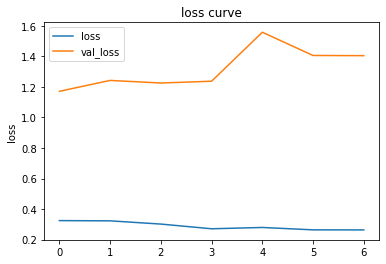

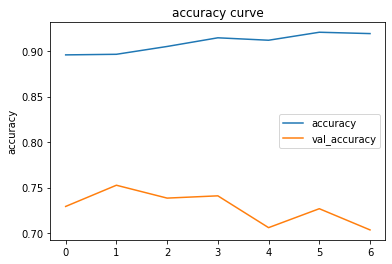

In [16]:
# predict
prediction = model.predict(testBatch)
prediction_label = prediction.argmax(axis=1)
filename = testBatch.filenames
for i in range(len(filename)):
    filename[i] = filename[i].replace('test/', '')
outputdf = pd.DataFrame()
outputdf['Name'] = filename
outputdf['Label'] = prediction_label
outputdf.to_csv('/Users/yangjunyu/py_project/DL/Models/CNN/ResNet50/hw3_vision/prediction.csv', index=False)

# show image
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()